# Preparation

In [531]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from statsmodels.tsa.api import VAR
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.api import MarkovAutoregression

In [4]:
raw_paths = glob.glob("TokenTerminal_raw/*")
raw_paths

['TokenTerminal_raw/Total value locked vs tradeable pairs for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Fees vs PF ratio (fully diluted) for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Code commits vs trade count for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Treasury vs net treasury for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Uni tokenholders vs circulating supply for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Price vs uni trading volume for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Active users (daily) vs core developers for Uniswap since launch 2024-09-10.csv',
 'TokenTerminal_raw/Gas used vs average trading volume (per user) for Uniswap since launch 2024-09-10.csv']

In [59]:
raws = [pd.read_csv(path) for path in raw_paths]
raw = raws[0]
for data in raws[1:]:
    raw = pd.merge(raw, data, on='Date', how='outer')


In [65]:
raw.dropna(inplace=True)
raw.set_index("Date", inplace=True)

In [66]:
raw

,Total value locked ($),Tradeable pairs (#),P/F ratio (fully diluted) (x),Fees ($),Code commits (#),Trade count (#),Treasury ($),Net treasury ($),Tokenholders (#),Circulating supply (#),Token trading volume ($),Price ($),Core developers (#),Active users (daily) (#),Gas used ($),Average trading volume (per user) ($)
Date,,,,,,,,,,,,,,,,
2020-09-22,2.023071e+09,10357.0,7.48,1092865.89,3.0,131226.0,1.678016e+09,0.35,84288.0,1.553918e+08,1.074199e+09,3.90,30.0,39579.0,1185601.24,9204.09
2020-09-23,1.942940e+09,10572.0,8.29,1099341.23,1.0,127741.0,1.881362e+09,0.33,83501.0,1.564701e+08,6.979289e+08,4.38,29.0,37794.0,843403.02,9695.91
2020-09-24,2.120227e+09,10810.0,9.64,938500.55,45.0,112883.0,2.207118e+09,0.00,80209.0,1.575485e+08,9.764303e+08,5.13,29.0,35628.0,688090.15,8780.55
2020-09-25,2.168452e+09,11024.0,9.20,850540.19,0.0,117687.0,2.115437e+09,0.00,81576.0,1.586268e+08,7.767605e+08,4.92,29.0,37050.0,640600.09,7652.18
2020-09-26,2.230276e+09,11275.0,9.00,792184.07,0.0,116784.0,2.083578e+09,0.00,82161.0,1.597052e+08,6.268236e+08,4.85,29.0,33962.0,569551.74,7775.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-04,4.889779e+09,1083839.0,12.27,1606854.20,38.0,1547906.0,2.573544e+09,1720.03,382243.0,9.949135e+08,1.649940e+08,6.44,26.0,497151.0,218810.12,3058.26
2024-09-05,4.788074e+09,1088617.0,12.33,1226072.20,38.0,1568237.0,2.517540e+09,1695.66,382296.0,9.953047e+08,3.890689e+08,6.30,28.0,592514.0,243799.40,1894.17
2024-09-06,4.572404e+09,1093076.0,12.08,2079094.02,20.0,1822266.0,2.461227e+09,1652.51,382333.0,9.956960e+08,1.331235e+08,6.16,28.0,665321.0,350792.01,3029.24


In [71]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1448 entries, 2020-09-22 to 2024-09-08
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Total value locked ($)                 1448 non-null   float64
 1   Tradeable pairs (#)                    1448 non-null   float64
 2   P/F ratio (fully diluted) (x)          1448 non-null   float64
 3   Fees ($)                               1448 non-null   float64
 4   Code commits (#)                       1448 non-null   float64
 5   Trade count (#)                        1448 non-null   float64
 6   Treasury ($)                           1448 non-null   float64
 7   Net treasury ($)                       1448 non-null   float64
 8   Tokenholders (#)                       1448 non-null   float64
 9   Circulating supply (#)                 1448 non-null   float64
 10  Token trading volume ($)               1448 non-null   float64

In [72]:
raw.describe()

,Total value locked ($),Tradeable pairs (#),P/F ratio (fully diluted) (x),Fees ($),Code commits (#),Trade count (#),Treasury ($),Net treasury ($),Tokenholders (#),Circulating supply (#),Token trading volume ($),Price ($),Core developers (#),Active users (daily) (#),Gas used ($),Average trading volume (per user) ($)
count,1.448000e+03,1.448000e+03,1448.000000,1.448000e+03,1448.000000,1.448000e+03,1.448000e+03,1.448000e+03,1448.000000,1.448000e+03,1.448000e+03,1448.000000,1448.000000,1448.000000,1.448000e+03,1448.000000
mean,6.795308e+09,2.055917e+05,12.313156,2.469833e+06,20.261050,3.924759e+05,4.683915e+09,6.076030e+05,305000.383287,6.378327e+08,3.237100e+08,11.054240,36.518646,106683.192680,1.961281e+06,20641.377735
std,4.692483e+09,2.271674e+05,5.812854,1.668633e+06,22.209615,4.292852e+05,3.710564e+09,8.691921e+05,83311.370912,2.398195e+08,4.001679e+08,8.597972,9.217764,108295.725355,2.809856e+06,16491.313806
min,1.569619e+09,1.035700e+04,4.040000,2.167074e+05,0.000000,6.965200e+04,8.313113e+08,0.000000e+00,80209.000000,1.553918e+08,2.183570e+07,1.930000,14.000000,26246.000000,5.744503e+04,914.010000
25%,4.159266e+09,5.656250e+04,8.190000,1.230365e+06,3.000000,1.301995e+05,2.315073e+09,1.211500e+01,269671.750000,4.430292e+08,1.083124e+08,5.490000,31.000000,47297.500000,5.026342e+05,8502.865000
50%,5.126165e+09,1.114215e+05,10.400000,2.096526e+06,14.000000,2.244945e+05,2.855790e+09,2.073850e+03,322364.500000,6.699223e+08,1.840829e+08,6.880000,36.000000,64886.500000,1.011436e+06,16547.360000
75%,7.541683e+09,2.921675e+05,14.932500,3.203818e+06,29.000000,4.177958e+05,5.885755e+09,1.321279e+06,370397.500000,8.543750e+08,3.483816e+08,14.210000,43.000000,120039.500000,2.232037e+06,27750.500000
max,3.157068e+10,1.101967e+06,31.280000,1.576943e+07,213.000000,2.153261e+06,1.857601e+10,6.754745e+06,382767.000000,9.964786e+08,4.724011e+09,43.250000,57.000000,750925.000000,4.240098e+07,137651.340000


### References
- https://tokenterminal.com/terminal/projects/uniswap
- https://docs.tokenterminal.com/docs/metrics-1

# Raw Data Visualization

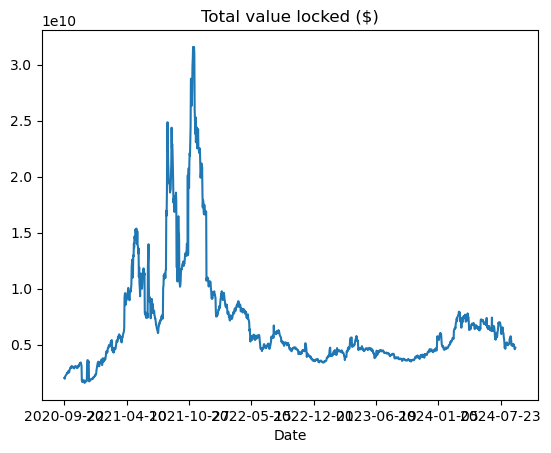

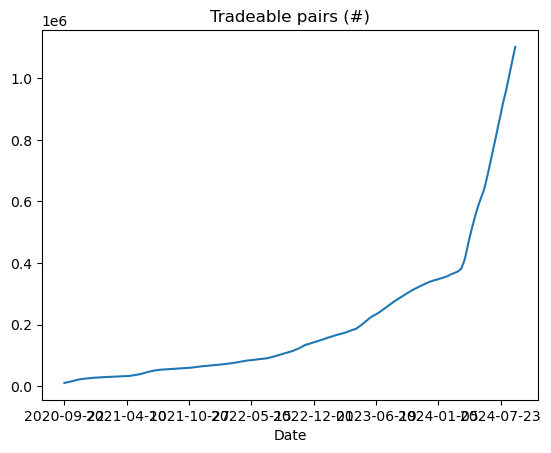

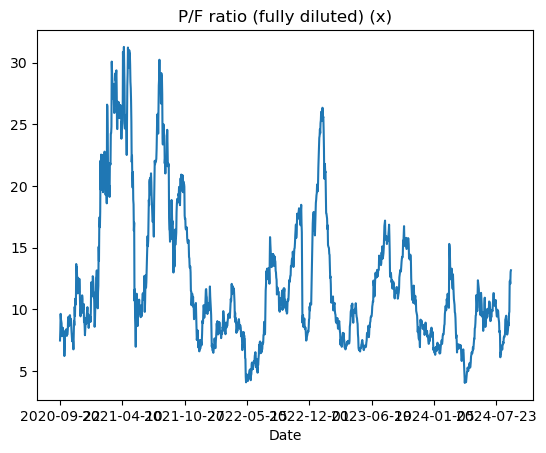

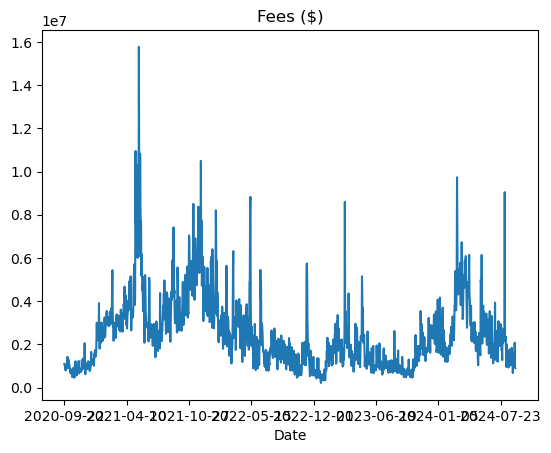

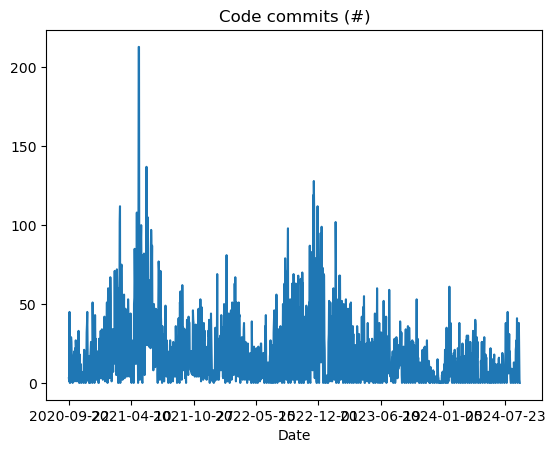

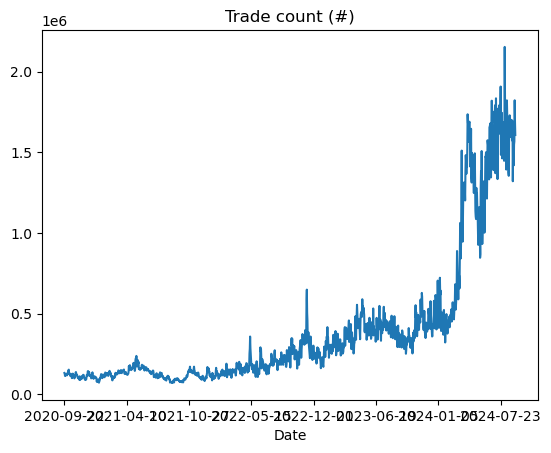

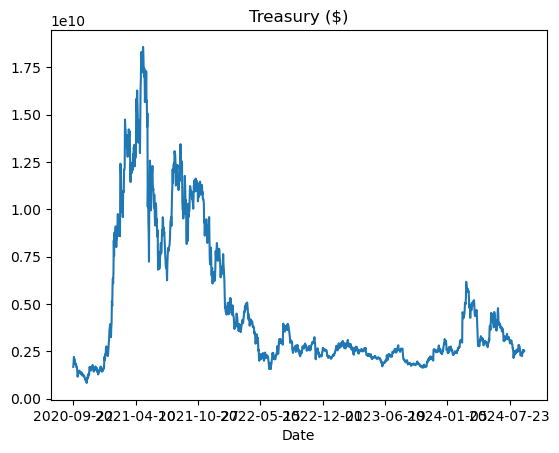

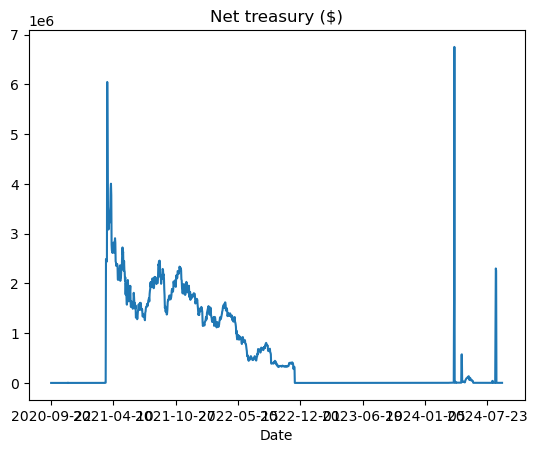

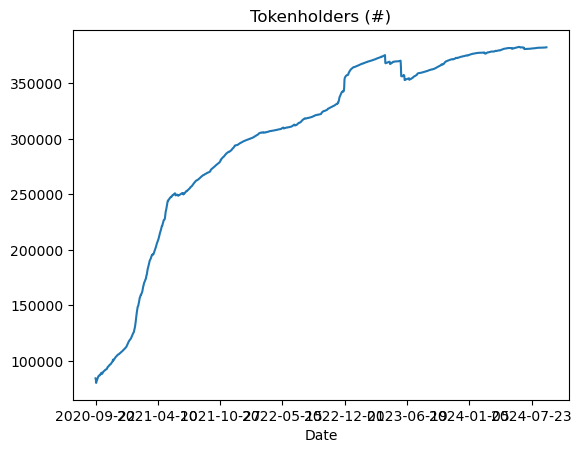

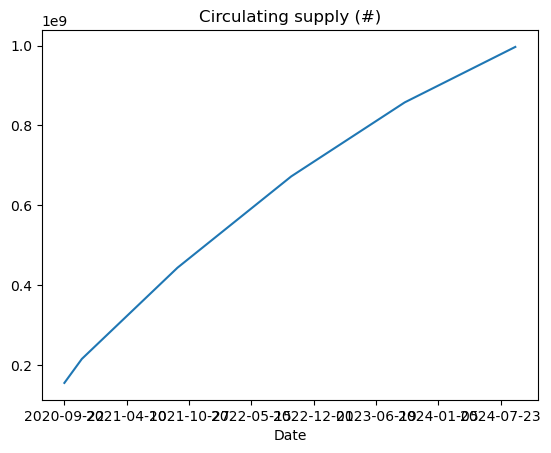

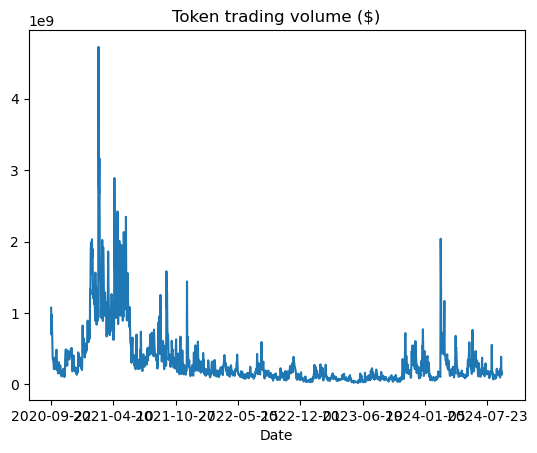

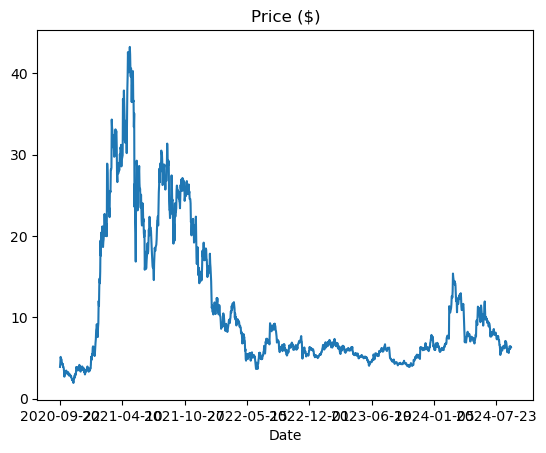

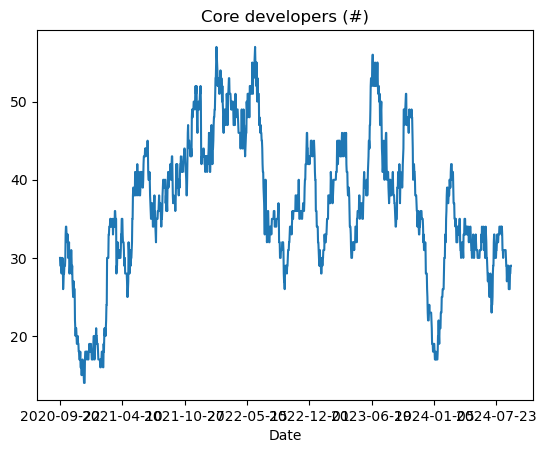

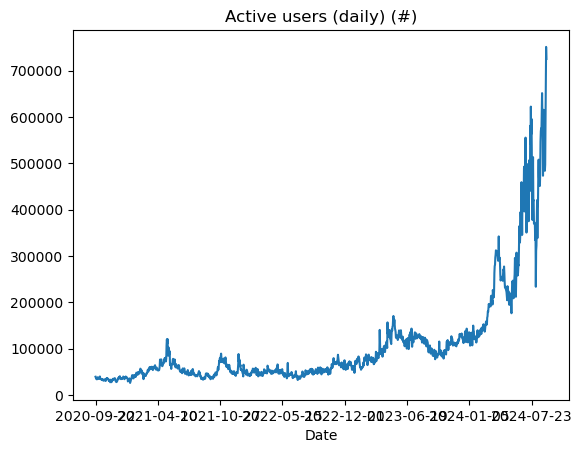

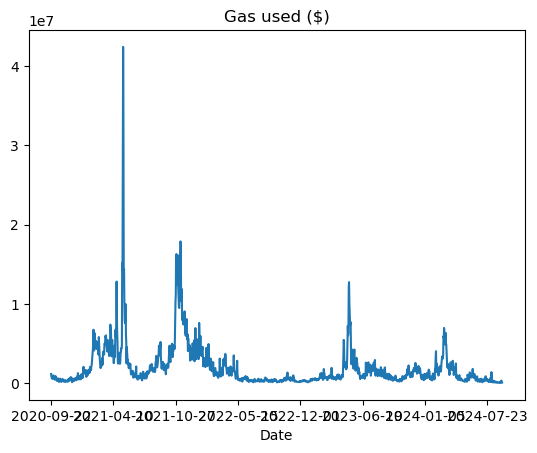

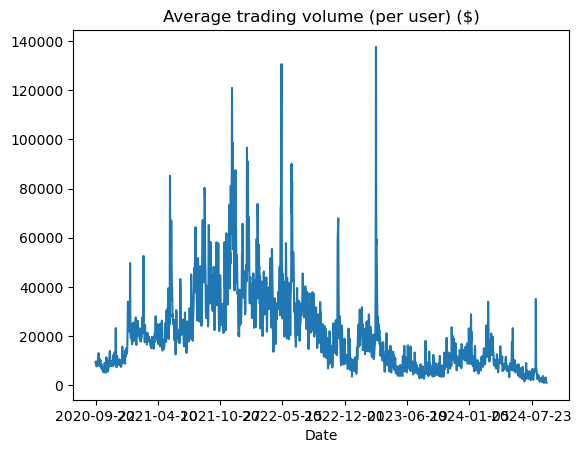

In [68]:
for col in raw.columns:
    raw[col].plot()
    plt.title(col)
    plt.show()

# Data Selection & Processing

In [73]:
raw.columns

Index(['Total value locked ($)', 'Tradeable pairs (#)',
       'P/F ratio (fully diluted) (x)', 'Fees ($)', 'Code commits (#)',
       'Trade count (#)', 'Treasury ($)', 'Net treasury ($)',
       'Tokenholders (#)', 'Circulating supply (#)',
       'Token trading volume ($)', 'Price ($)', 'Core developers (#)',
       'Active users (daily) (#)', 'Gas used ($)',
       'Average trading volume (per user) ($)'],
      dtype='object')

In [246]:
selected_cols = ['Total value locked ($)', 
                 'Fees ($)', 
#                 'Code commits (#)',
                 'Trade count (#)', 
#                 'Net treasury ($)',
                 'Tokenholders (#)', 
                 'Circulating supply (#)',
                 'Token trading volume ($)', 
                 'Price ($)', 
                 'Core developers (#)',
                 'Active users (daily) (#)', 
                 'Gas used ($)'
                ]
mapper = {
    'Total value locked ($)':"TVL", 
    'Fees ($)':"Fee", 
#    'Code commits (#)':"CodeCommits",
    'Trade count (#)':"TradeCount", 
#    'Net treasury ($)':"NetTreasury",
    'Tokenholders (#)':"Holders", 
    'Circulating supply (#)':"Supply",
    'Token trading volume ($)':"TransactionVolume", 
    'Price ($)':"Price", 
    'Core developers (#)':"Developers",
    'Active users (daily) (#)':"ActiveUsers", 
    'Gas used ($)':"Gas"
}

In [247]:
selected = raw[selected_cols].rename(mapper, axis=1)


In [252]:
selected

,TVL,Fee,TradeCount,Holders,Supply,TransactionVolume,Price,Developers,ActiveUsers,Gas
Date,,,,,,,,,,
2020-09-22,2.023071e+09,1092865.89,131226.0,84288.0,1.553918e+08,1.074199e+09,3.90,30.0,39579.0,1185601.24
2020-09-23,1.942940e+09,1099341.23,127741.0,83501.0,1.564701e+08,6.979289e+08,4.38,29.0,37794.0,843403.02
2020-09-24,2.120227e+09,938500.55,112883.0,80209.0,1.575485e+08,9.764303e+08,5.13,29.0,35628.0,688090.15
2020-09-25,2.168452e+09,850540.19,117687.0,81576.0,1.586268e+08,7.767605e+08,4.92,29.0,37050.0,640600.09
2020-09-26,2.230276e+09,792184.07,116784.0,82161.0,1.597052e+08,6.268236e+08,4.85,29.0,33962.0,569551.74
...,...,...,...,...,...,...,...,...,...,...
2024-09-04,4.889779e+09,1606854.20,1547906.0,382243.0,9.949135e+08,1.649940e+08,6.44,26.0,497151.0,218810.12
2024-09-05,4.788074e+09,1226072.20,1568237.0,382296.0,9.953047e+08,3.890689e+08,6.30,28.0,592514.0,243799.40
2024-09-06,4.572404e+09,2079094.02,1822266.0,382333.0,9.956960e+08,1.331235e+08,6.16,28.0,665321.0,350792.01


In [536]:
selected.describe()

,TVL,Fee,TradeCount,Holders,Supply,TransactionVolume,Price,Developers,ActiveUsers,Gas
count,1.448000e+03,1.448000e+03,1.448000e+03,1448.000000,1.448000e+03,1.448000e+03,1448.000000,1448.000000,1448.000000,1.448000e+03
mean,6.795308e+09,2.469833e+06,3.924759e+05,305000.383287,6.378327e+08,3.237100e+08,11.054240,36.518646,106683.192680,1.961281e+06
std,4.692483e+09,1.668633e+06,4.292852e+05,83311.370912,2.398195e+08,4.001679e+08,8.597972,9.217764,108295.725355,2.809856e+06
min,1.569619e+09,2.167074e+05,6.965200e+04,80209.000000,1.553918e+08,2.183570e+07,1.930000,14.000000,26246.000000,5.744503e+04
25%,4.159266e+09,1.230365e+06,1.301995e+05,269671.750000,4.430292e+08,1.083124e+08,5.490000,31.000000,47297.500000,5.026342e+05
50%,5.126165e+09,2.096526e+06,2.244945e+05,322364.500000,6.699223e+08,1.840829e+08,6.880000,36.000000,64886.500000,1.011436e+06
75%,7.541683e+09,3.203818e+06,4.177958e+05,370397.500000,8.543750e+08,3.483816e+08,14.210000,43.000000,120039.500000,2.232037e+06
max,3.157068e+10,1.576943e+07,2.153261e+06,382767.000000,9.964786e+08,4.724011e+09,43.250000,57.000000,750925.000000,4.240098e+07


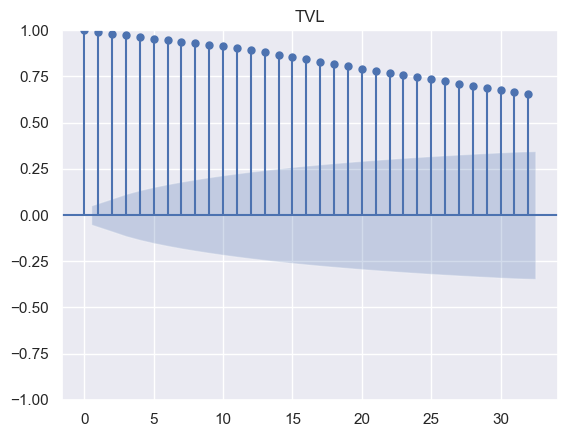

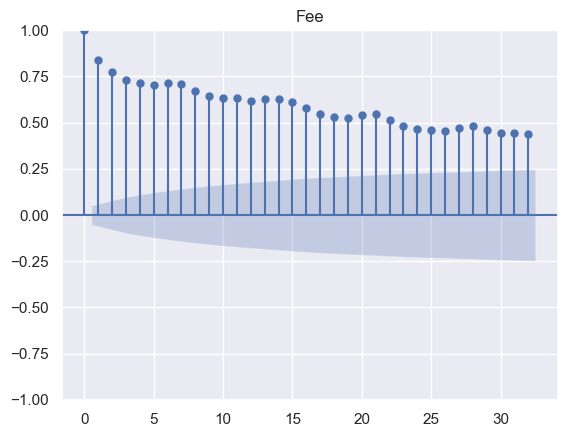

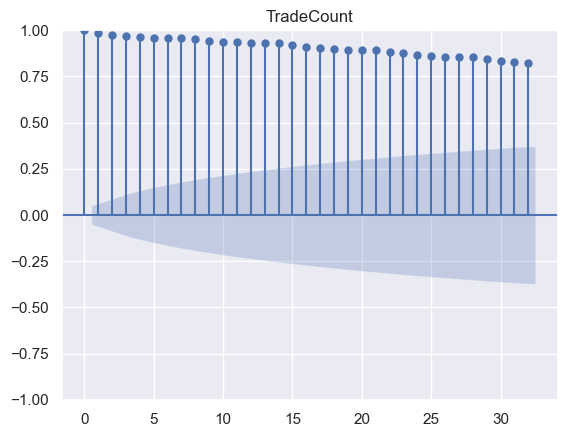

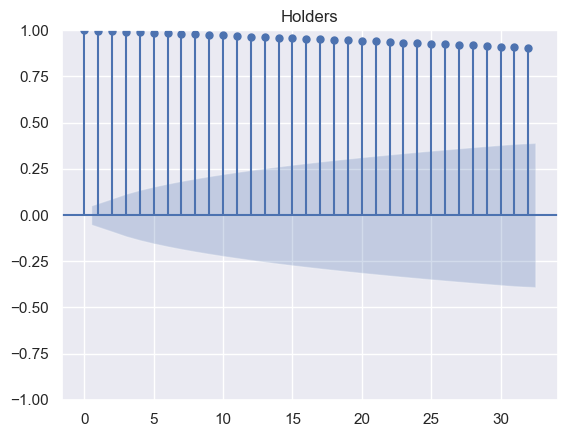

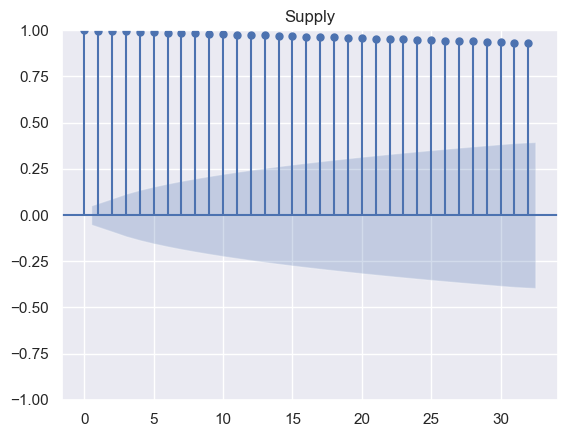

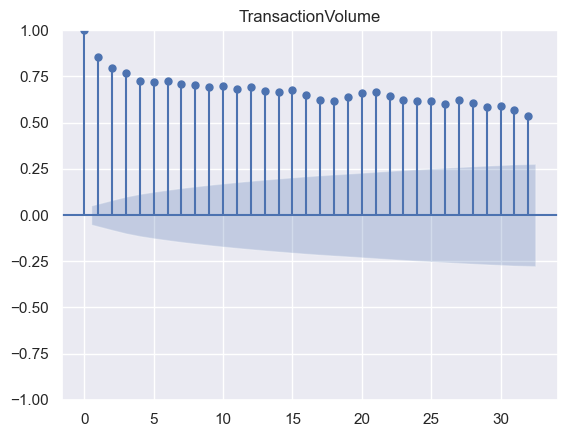

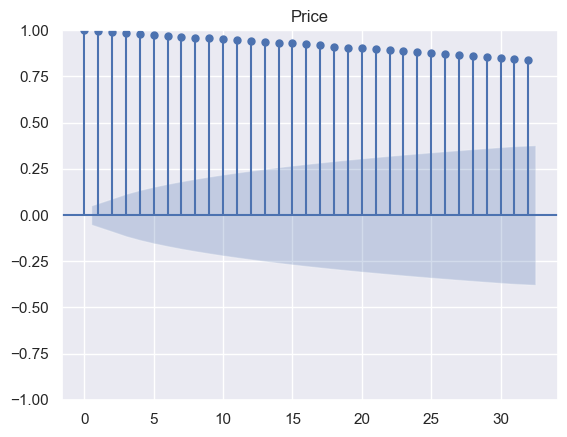

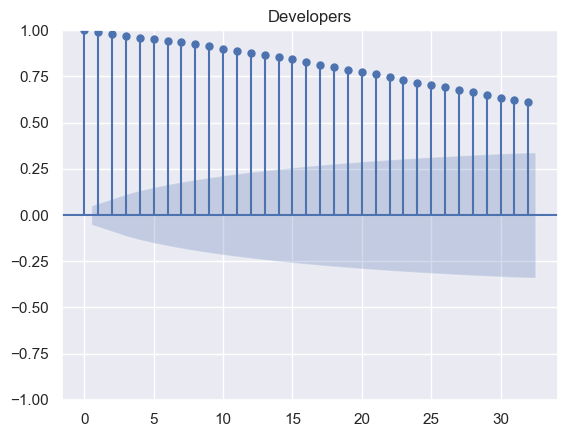

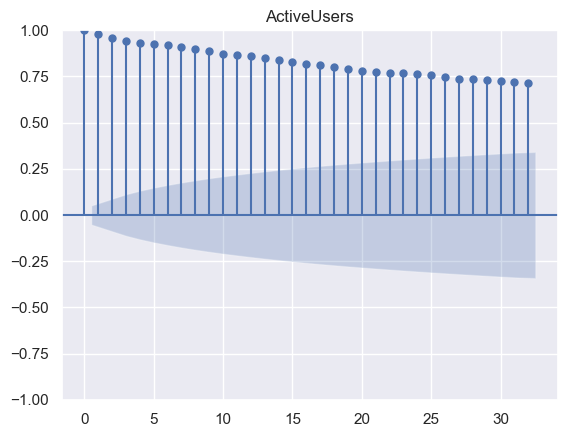

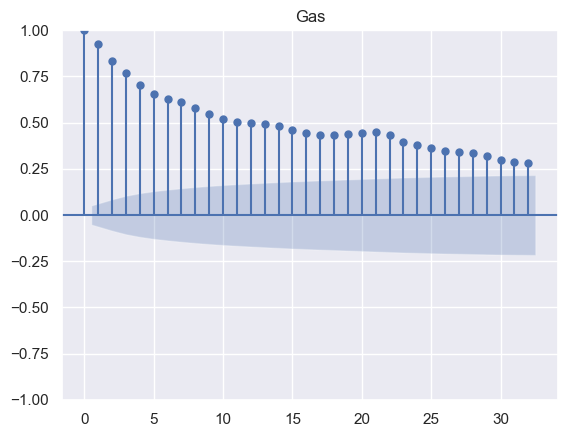

In [253]:
for col in selected.columns:
    plot_acf(selected[col])
    plt.title(col)
    plt.show()

In [254]:
non_price_cols = [col for col in selected.columns if col not in ["Price"]]
dif = pd.concat([selected[non_price_cols].pct_change(), selected["Price"].pct_change()], axis=1).dropna(how="any")
#dif = pd.concat([selected[non_price_cols].diff(1), selected["Price"].pct_change()], axis=1).dropna(how="any")
dif.columns = ["pct_"+col for col in dif.columns[:-1]]+["Return"]


In [255]:
dif

,pct_TVL,pct_Fee,pct_TradeCount,pct_Holders,pct_Supply,pct_TransactionVolume,pct_Developers,pct_ActiveUsers,pct_Gas,Return
Date,,,,,,,,,,
2020-09-23,-0.039609,0.005925,-0.026557,-0.009337,0.006940,-0.350279,-0.033333,-0.045100,-0.288628,0.123077
2020-09-24,0.091247,-0.146306,-0.116313,-0.039425,0.006892,0.399040,0.000000,-0.057311,-0.184150,0.171233
2020-09-25,0.022745,-0.093724,0.042557,0.017043,0.006845,-0.204490,0.000000,0.039912,-0.069017,-0.040936
2020-09-26,0.028511,-0.068611,-0.007673,0.007171,0.006798,-0.193029,0.000000,-0.083347,-0.110909,-0.014228
2020-09-27,0.018208,0.244595,0.042189,0.010041,0.006752,-0.419414,-0.034483,0.008215,0.119434,-0.008247
...,...,...,...,...,...,...,...,...,...,...
2024-09-04,0.007673,0.535614,0.090790,0.000063,0.000393,-0.261908,0.000000,0.027605,0.765605,0.067993
2024-09-05,-0.020799,-0.236974,0.013135,0.000139,0.000393,1.358079,0.076923,0.191819,0.114205,-0.021739
2024-09-06,-0.045043,0.695735,0.161984,0.000097,0.000393,-0.657841,0.000000,0.122878,0.438855,-0.022222


In [256]:
dif.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1447 entries, 2020-09-23 to 2024-09-08
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_TVL                1447 non-null   float64
 1   pct_Fee                1447 non-null   float64
 2   pct_TradeCount         1447 non-null   float64
 3   pct_Holders            1447 non-null   float64
 4   pct_Supply             1447 non-null   float64
 5   pct_TransactionVolume  1447 non-null   float64
 6   pct_Developers         1447 non-null   float64
 7   pct_ActiveUsers        1447 non-null   float64
 8   pct_Gas                1447 non-null   float64
 9   Return                 1447 non-null   float64
dtypes: float64(10)
memory usage: 124.4+ KB


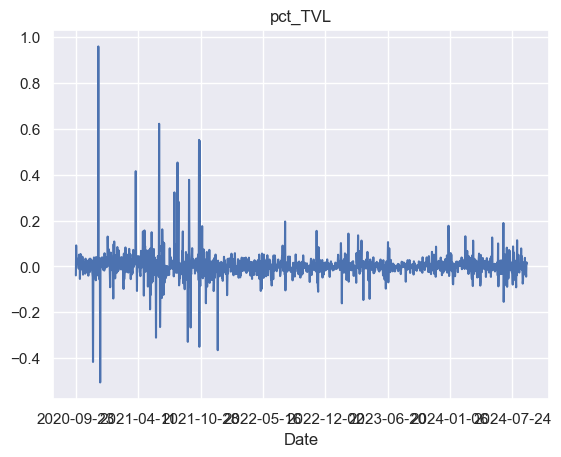

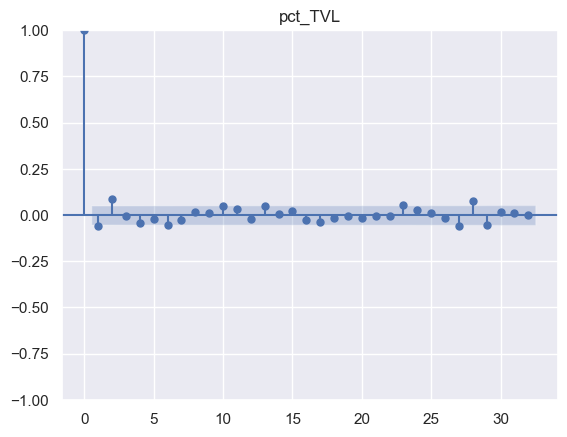

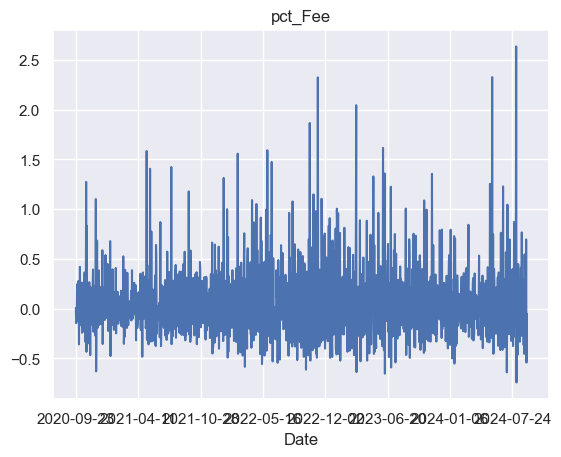

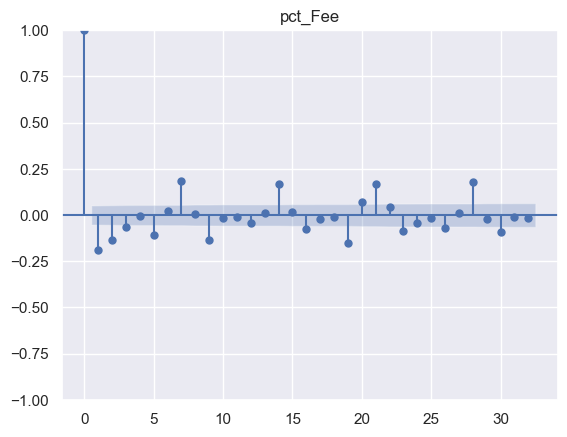

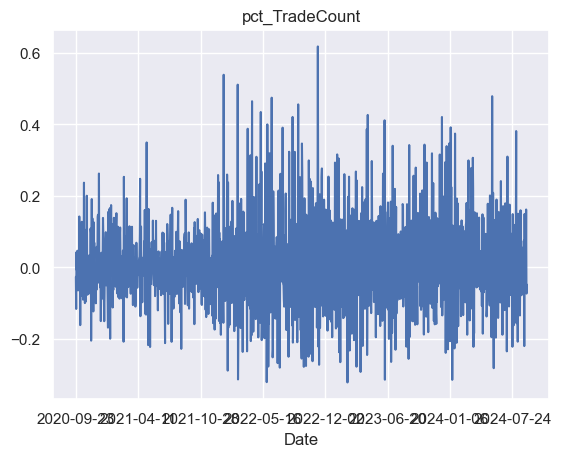

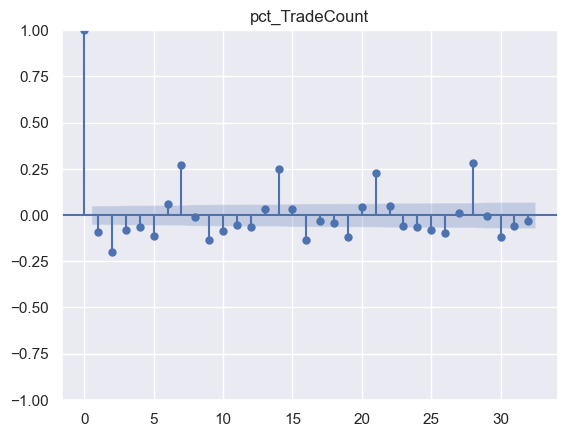

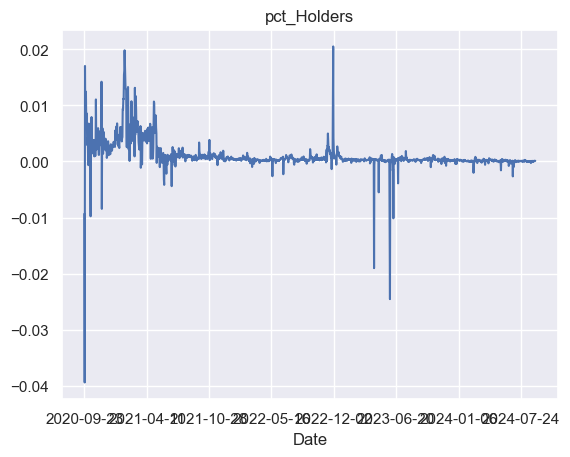

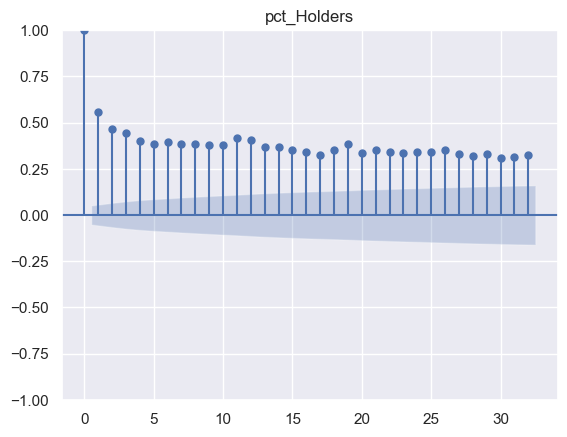

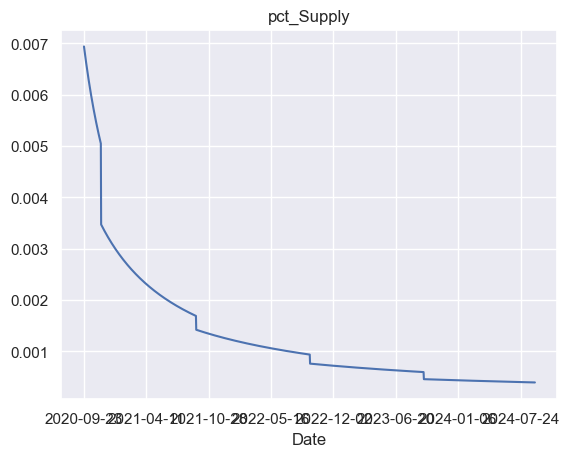

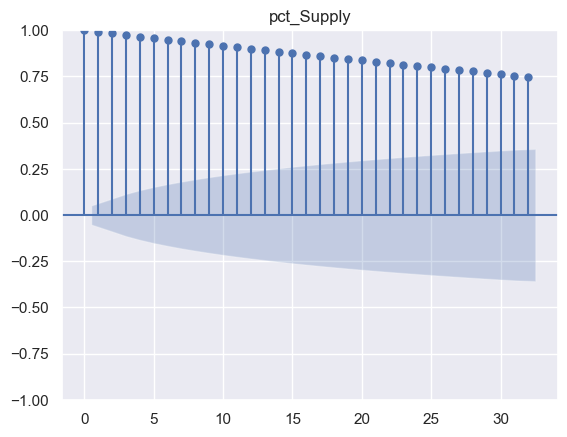

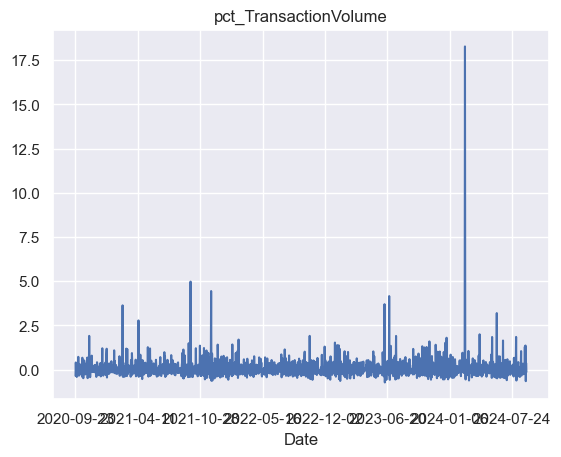

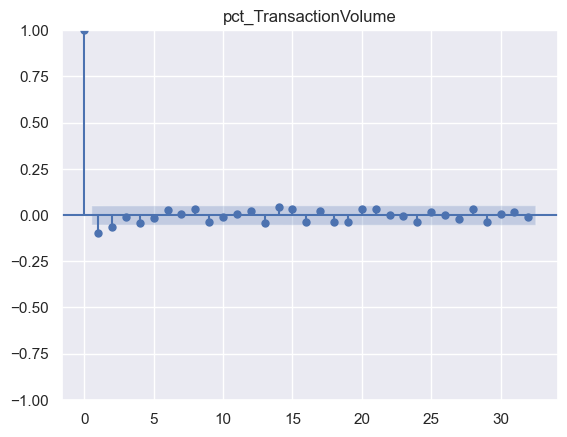

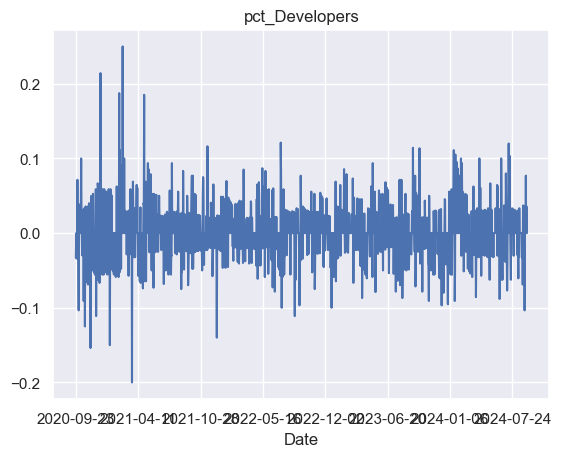

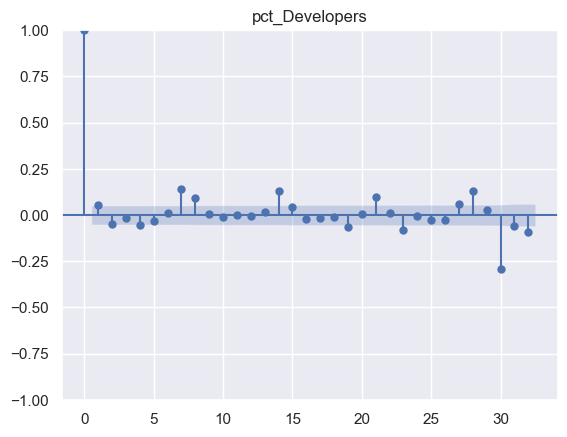

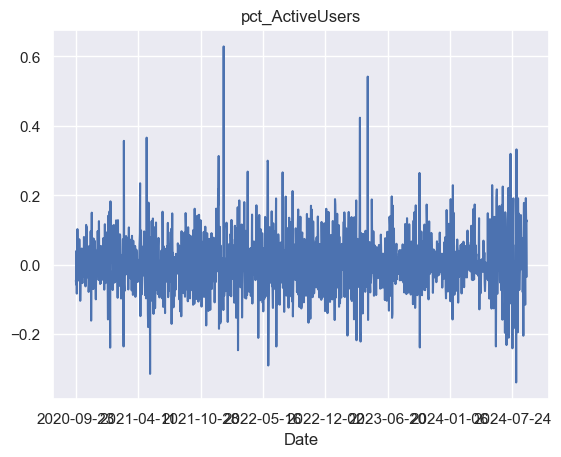

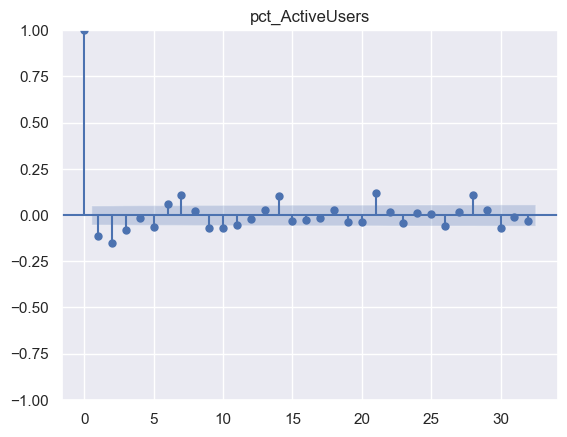

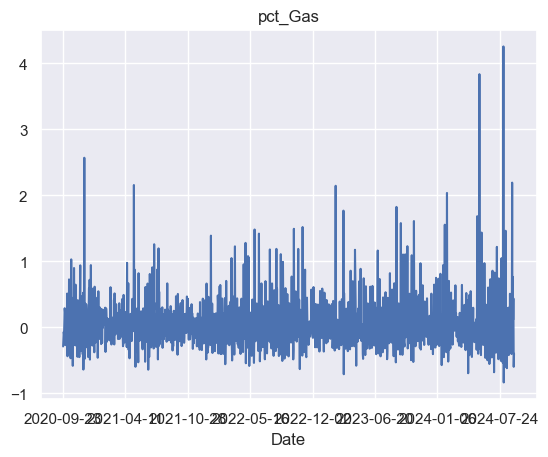

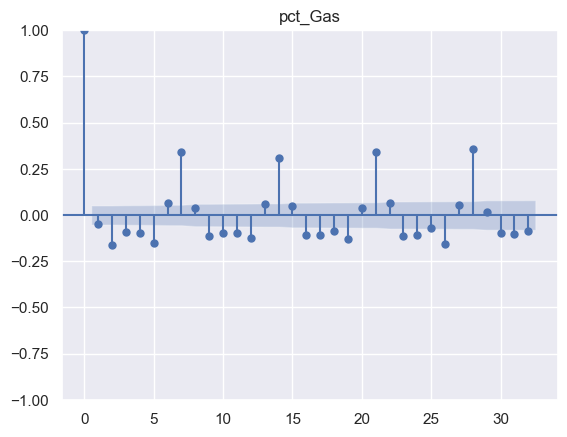

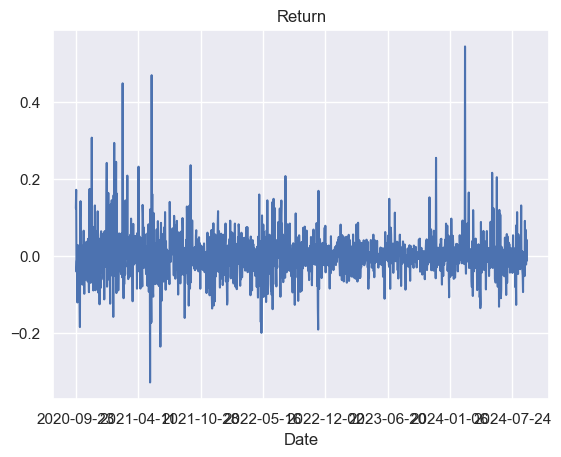

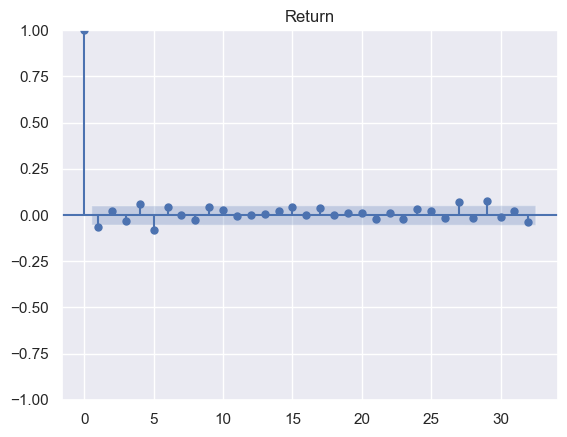

In [257]:
for col in dif.columns:
    dif[col].plot()
    plt.title(col)
    plt.show()
    plot_acf(dif[col])
    plt.title(col)
    plt.show()

In [258]:
full = pd.concat([selected, dif], axis=1).dropna()
full

,TVL,Fee,TradeCount,Holders,Supply,TransactionVolume,Price,Developers,ActiveUsers,Gas,pct_TVL,pct_Fee,pct_TradeCount,pct_Holders,pct_Supply,pct_TransactionVolume,pct_Developers,pct_ActiveUsers,pct_Gas,Return
Date,,,,,,,,,,,,,,,,,,,,
2020-09-23,1.942940e+09,1099341.23,127741.0,83501.0,1.564701e+08,6.979289e+08,4.38,29.0,37794.0,843403.02,-0.039609,0.005925,-0.026557,-0.009337,0.006940,-0.350279,-0.033333,-0.045100,-0.288628,0.123077
2020-09-24,2.120227e+09,938500.55,112883.0,80209.0,1.575485e+08,9.764303e+08,5.13,29.0,35628.0,688090.15,0.091247,-0.146306,-0.116313,-0.039425,0.006892,0.399040,0.000000,-0.057311,-0.184150,0.171233
2020-09-25,2.168452e+09,850540.19,117687.0,81576.0,1.586268e+08,7.767605e+08,4.92,29.0,37050.0,640600.09,0.022745,-0.093724,0.042557,0.017043,0.006845,-0.204490,0.000000,0.039912,-0.069017,-0.040936
2020-09-26,2.230276e+09,792184.07,116784.0,82161.0,1.597052e+08,6.268236e+08,4.85,29.0,33962.0,569551.74,0.028511,-0.068611,-0.007673,0.007171,0.006798,-0.193029,0.000000,-0.083347,-0.110909,-0.014228
2020-09-27,2.270886e+09,985947.97,121711.0,82986.0,1.607835e+08,3.639252e+08,4.81,28.0,34241.0,637575.54,0.018208,0.244595,0.042189,0.010041,0.006752,-0.419414,-0.034483,0.008215,0.119434,-0.008247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-04,4.889779e+09,1606854.20,1547906.0,382243.0,9.949135e+08,1.649940e+08,6.44,26.0,497151.0,218810.12,0.007673,0.535614,0.090790,0.000063,0.000393,-0.261908,0.000000,0.027605,0.765605,0.067993
2024-09-05,4.788074e+09,1226072.20,1568237.0,382296.0,9.953047e+08,3.890689e+08,6.30,28.0,592514.0,243799.40,-0.020799,-0.236974,0.013135,0.000139,0.000393,1.358079,0.076923,0.191819,0.114205,-0.021739
2024-09-06,4.572404e+09,2079094.02,1822266.0,382333.0,9.956960e+08,1.331235e+08,6.16,28.0,665321.0,350792.01,-0.045043,0.695735,0.161984,0.000097,0.000393,-0.657841,0.000000,0.122878,0.438855,-0.022222


In [374]:
Q1 = full['Return'].quantile(0.25)
Q3 = full['Return'].quantile(0.75)
IQR = Q3 - Q1

multiplier = 1
lower_bound = Q1 - multiplier * IQR
upper_bound = Q3 + multiplier * IQR

filtered_full = full[(full['Return'] >= lower_bound) & (full['Return'] <= upper_bound)]

# Processed Data Visualization

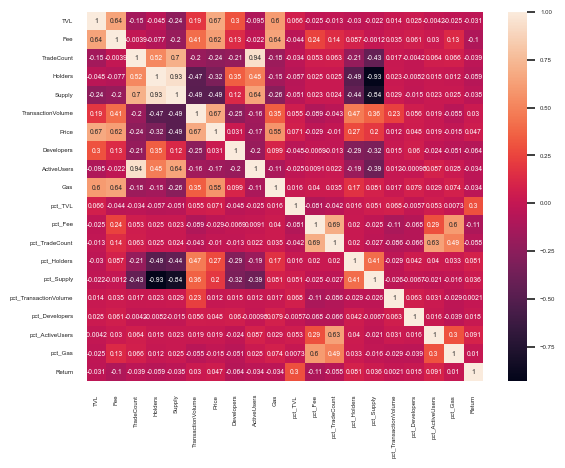

In [376]:
sns.heatmap(full.corr(), annot=True)
sns.set(font_scale=0.4) 

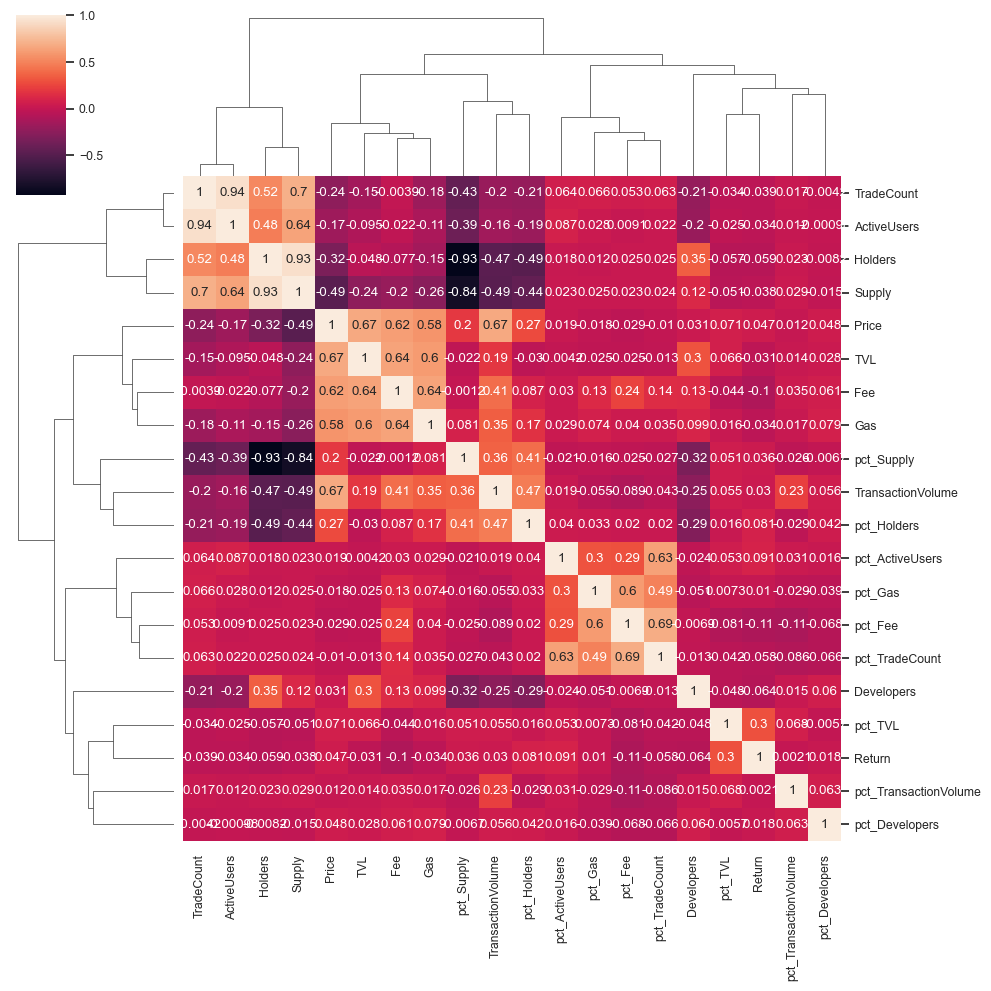

In [378]:
sns.clustermap(full.corr(), annot=True)
sns.set(font_scale=0.8) 

# Statistical Models

## OLS

In [379]:
filtered_full.columns

Index(['TVL', 'Fee', 'TradeCount', 'Holders', 'Supply', 'TransactionVolume',
       'Price', 'Developers', 'ActiveUsers', 'Gas', 'pct_TVL', 'pct_Fee',
       'pct_TradeCount', 'pct_Holders', 'pct_Supply', 'pct_TransactionVolume',
       'pct_Developers', 'pct_ActiveUsers', 'pct_Gas', 'Return'],
      dtype='object')

In [388]:
dep = filtered_full["Return"]
indep_cols = [
    "pct_TVL",
    "pct_Fee",
#    "Fee",
#    "pct_Holders",
    "pct_TransactionVolume",
    "pct_Developers",
    "pct_ActiveUsers",
#    "TransactionVolume"
#    "pct_Gas",
    "Supply"
]
indep = add_constant(filtered_full[indep_cols])

In [391]:
ols = OLS(endog=dep, exog=indep).fit()#cov_type="HC3")

In [392]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     21.38
Date:                Wed, 11 Sep 2024   Prob (F-statistic):           4.81e-24
Time:                        00:54:14   Log-Likelihood:                 2471.3
No. Observations:                1301   AIC:                            -4929.
Df Residuals:                    1294   BIC:                            -4892.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0028      0.003     -0.935      0.350      -0.009       0.003
pct_TVL                   0.1921      0.018     10.747      0.000       0.157       0.227
pct_Fee                  -0.0070      0.003     -2.109      0.035      -0.013      -0.000
pct_TransactionVolume    -0.0028      0.001     -1.935      0.053      -0.006    3.89e-05
pct_Developers           -0.0037      0.028     -0.136      0.892      -0.058       0.050
pct_ActiveUsers           0.0361      0.013      2.834      0.005       0.011       0.061
Supply                 2.406e-12   4.32e-12      0.556      0.578   -6.08e-12    1.09e-11
==============================================================================
Omnibus:                        2.776   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.670
Skew:                           0.088   Prob(JB):                        0.263
Kurtosis:                       3.136   Cond. No.                     1.90e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

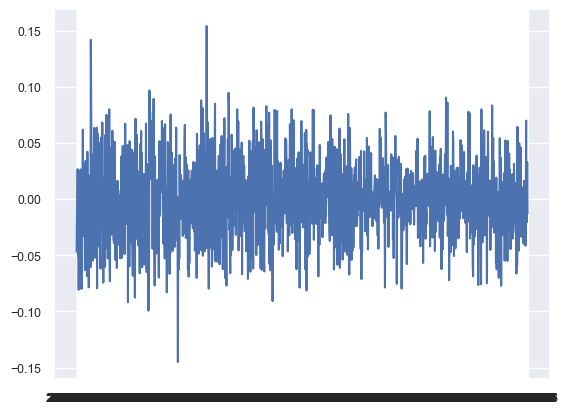

In [383]:
plt.plot(ols.resid)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  1.,  2.,  1.,  6.,  7.,  4.,  4., 10.,
         9., 15., 11., 12., 14., 16., 22., 26., 22., 13., 26., 29., 25.,
        24., 40., 44., 34., 41., 44., 37., 49., 45., 43., 49., 34., 34.,
        44., 40., 38., 35., 42., 30., 35., 20., 20., 25., 25., 15., 17.,
        22., 18.,  8.,  9., 11.,  6.,  9.,  3.,  6.,  6.,  9.,  4.,  2.,
         2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.1450556 , -0.14206483, -0.13907406, -0.13608329, -0.13309253,
        -0.13010176, -0.12711099, -0.12412023, -0.12112946, -0.11813869,
        -0.11514793, -0.11215716, -0.10916639, -0.10617563, -0.10318486,
        -0.10019409, -0.09720333, -0.09421256, -0.09122179, -0.08823102,
        -0.08524026, -0.08224949, -0.07925872, -0.07626796, -0.07327719,
        -0.07028642, -0.06729566, -0.06430489, -0.06131412, -0.058323

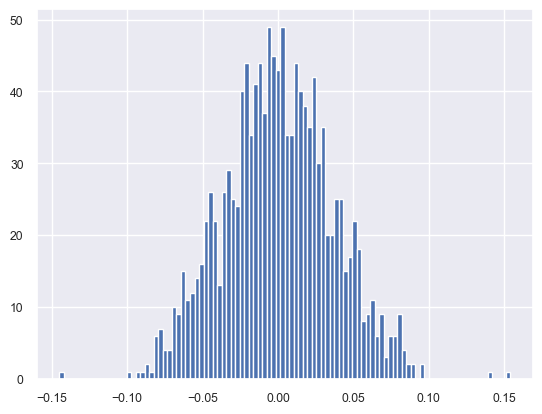

In [384]:
plt.hist(ols.resid, bins=100)

## VECM

In [394]:
raw_columns = ['TVL', 'Fee', 'TradeCount', 'Holders', 'Supply', 'TransactionVolume', 'Price', 'Developers', 'ActiveUsers', 'Gas']

In [399]:
for col in raw_columns:
    print(col)
    print(ADF(filtered_full[col], max_lags=10).summary())
    print("\n")

TVL
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.886
P-value                         0.047
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Fee
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.792
P-value                         0.003
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


TradeCount
   Augmented Dickey-Fuller Results   
Test Statistic                  0.896
P-value                         0.993
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.

/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

In [397]:
for col in raw_columns:
    print(col)
    print(KPSS(filtered_full[col], lags=10).summary())
    print("\n")

TVL
    KPSS Stationarity Test Results   
Test Statistic                  2.185
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Fee
    KPSS Stationarity Test Results   
Test Statistic                  1.768
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


TradeCount
    KPSS Stationarity Test Results   
Test Statistic                  7.235
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%),

In [400]:
for col in raw_columns:
    print(col)
    print(PhillipsPerron(filtered_full[col], lags=10).summary())
    print("\n")

TVL
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.680
P-value                         0.078
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Fee
     Phillips-Perron Test (Z-tau)    
Test Statistic                -10.091
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


TradeCount
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.326
P-value                         0.922
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.

/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/arch/unitroot/unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

series with unitroot are:
- TradeCount
- Price
- ActiveUsers

Controversial:
- TVL
- Holders
- Supply
- TransactionVolume
- Developers
- Gas
- Fee

In [517]:
vecm_cols = ["Price", "ActiveUsers", "Holders", "TVL", "Fee", "TransactionVolume", "Developers"]
order = vecm.select_order(full[vecm_cols],maxlags=7) 
print(order.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       138.0       138.2   8.309e+59       138.0
1       137.6      137.9*   5.485e+59      137.7*
2       137.5       138.1   5.296e+59       137.7
3       137.5       138.2   5.148e+59       137.8
4       137.5       138.4   5.085e+59       137.8
5      137.4*       138.5  4.909e+59*       137.9
6       137.5       138.7   5.003e+59       137.9
7       137.5       138.9   4.987e+59       138.0
-------------------------------------------------


/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-p

In [518]:
rank = vecm.select_coint_rank(full[vecm_cols], det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.1)
print(rank.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 10% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          268.9          46.56
  1   2          185.0          40.52
  2   3          56.59          34.42
  3   4          18.25          28.24
-------------------------------------


In [519]:
rank = vecm.select_coint_rank(full[vecm_cols], det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.1)
print(rank.summary())

Johansen cointegration test using trace test statistic with 10% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   7          553.4          133.8
  1   7          284.5          102.5
  2   7          99.49          75.10
  3   7          42.89          51.65
-------------------------------------


In [520]:
model = vecm.VECM(full[vecm_cols], k_ar_diff=1, coint_rank=3, deterministic='coli', seasons=0) 
res = model.fit()
print(res.summary())

  Det. terms outside the coint. relation & lagged endog. parameters for equation Price  
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0767      0.097      0.789      0.430      -0.114       0.267
L1.Price                -0.1063      0.029     -3.709      0.000      -0.162      -0.050
L1.ActiveUsers       -1.788e-06   1.54e-06     -1.159      0.246   -4.81e-06    1.23e-06
L1.Holders            8.461e-06   4.99e-05      0.170      0.865   -8.93e-05       0.000
L1.TVL                8.152e-11   3.88e-11      2.100      0.036    5.43e-12    1.58e-10
L1.Fee                7.178e-08   2.96e-08      2.429      0.015    1.39e-08     1.3e-07
L1.TransactionVolume -1.149e-10   1.27e-10     -0.906      0.365   -3.63e-10    1.34e-10
L1.Developers           -0.0083      0.019     -0.435      0.663      -0.046       0.029
Det. terms outside th

/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Markov Switching Model

In [523]:
order = arma_order_select_ic(y=full["Return"], max_ar=7, max_ma=7, trend="n", ic=["bic", "aic", "hqic"])

/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [524]:
order

{'bic':              0            1            2            3            4  \
 0 -3966.148100 -3964.231662 -3957.330992 -3950.739140 -3947.700013   
 1 -3964.408316 -3958.671133 -3956.036002 -3951.466751 -3948.537176   
 2 -3957.512527 -3950.196830 -3949.014201 -3941.837160 -3948.978431   
 3 -3951.471955 -3951.083515 -3942.933299 -3949.380056 -3942.076105   
 4 -3949.161473 -3947.441568 -3947.786329 -3930.162802 -3934.831035   
 5 -3949.632891 -3943.251986 -3933.898988 -3930.130093 -3927.556165   
 6 -3943.843508 -3936.589969 -3929.608374 -3927.239604 -3920.217176   
 7 -3936.747903 -3929.446557 -3922.175912 -3918.412126 -3912.185693   
 
              5            6            7  
 0 -3950.252431 -3945.478300 -3938.206595  
 1 -3944.699259 -3938.196106 -3930.926546  
 2 -3939.377902 -3931.296282 -3924.149650  
 3 -3934.666923 -3930.367048 -3919.376353  
 4 -3926.647839 -3922.739523 -3912.548052  
 5 -3920.829209 -3916.080301 -3905.355844  
 6 -3912.688545 -3905.986417 -3898.641764  


In [528]:
markov_exogs = ["pct_Holders", "pct_ActiveUsers", "pct_Fee", "pct_Developers", "pct_TVL", "pct_TransactionVolume"]
markov = MarkovAutoregression(endog=full["Return"], k_regimes=2, order=3, exog=full[markov_exogs], exog_tvtp=full[markov_exogs], switching_ar=True, switching_trend=True, switching_exog=True, switching_variance=True).fit()


/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yugonagatake/opt/anaconda3/envs/zemi/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [529]:
markov.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                   Return   No. Observations:                 1444
Model:             MarkovAutoregression   Log Likelihood                2396.411
Date:                  Wed, 11 Sep 2024   AIC                          -4724.822
Time:                          02:33:01   BIC                          -4545.467
Sample:                      09-23-2020   HQIC                         -4657.879
                           - 09-08-2024                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.447      0.655      -0.002       0.004
x1             0.3735      0.102      3.667      0.000       0.174       0.573
x2             0.0303      0.024      1.253      0.210      -0.017       0.078
x3             0.0074      0.007      1.085      0.278      -0.006       0.021
x4             0.0538      0.041      1.324      0.186      -0.026       0.134
x5             0.0748      0.024      3.079      0.002       0.027       0.122
x6             0.0052      0.002      2.553      0.011       0.001       0.009
sigma2         0.0005   4.23e-05     11.881      0.000       0.000       0.001
ar.L1         -0.2369      0.048     -4.888      0.000      -0.332      -0.142
ar.L2         -0.0910      0.032     -2.832      0.005      -0.154      -0.028
ar.L3         -0.1474      0.027     -5.415      0.000      -0.201      -0.094
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0025      0.002     -1.394      0.163      -0.006       0.001
x1             1.7449      0.434      4.023      0.000       0.895       2.595
x2            -0.0110      0.019     -0.591      0.555      -0.047       0.025
x3            -0.0089      0.004     -2.103      0.035      -0.017      -0.001
x4            -0.0387      0.047     -0.820      0.412      -0.131       0.054
x5             1.3165      0.047     27.786      0.000       1.224       1.409
x6             0.0018      0.004      0.479      0.632      -0.005       0.009
sigma2         0.0043      0.000     15.229      0.000       0.004       0.005
ar.L1          0.0225      0.044      0.511      0.609      -0.064       0.109
ar.L2         -0.0229      0.035     -0.654      0.513      -0.091       0.046
ar.L3          0.0248      0.029      0.868      0.386      -0.031       0.081
                           Regime transition parameters                          
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
p[0->0].tvtp0    -0.1106        nan        nan        nan         nan         nan
p[1->0].tvtp0    -0.3048        nan        nan        nan         nan         nan
p[0->0].tvtp1     0.3057      2.649      0.115      0.908      -4.886       5.497
p[1->0].tvtp1     0.5714      2.781      0.205      0.837      -4.879       6.022
p[0->0].tvtp2    -0.9222      0.947     -0.974      0.330      -2.778       0.934
p[1->0].tvtp2    -1.1152      0.785     -1.421      0.155      -2.654       0.423
p[0->0].tvtp3    -0.9337      4.6

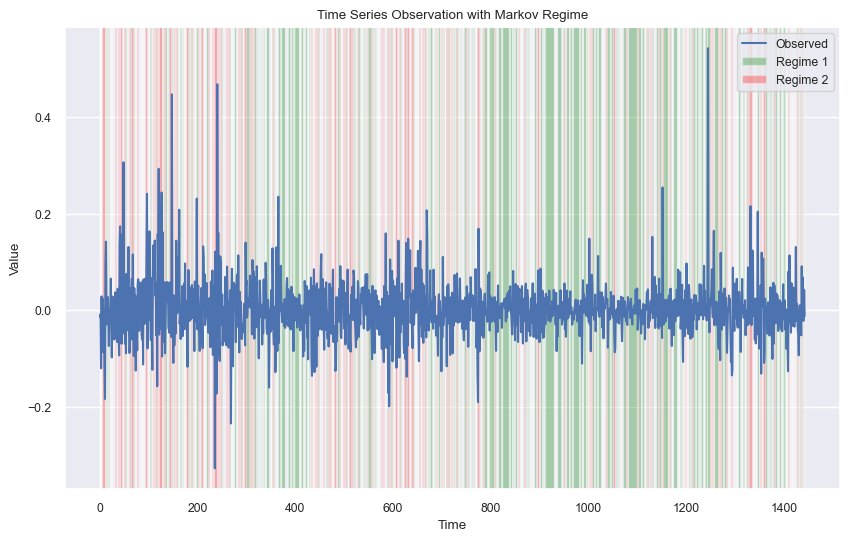

In [530]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(markov.data.endog, label='Observed')

regimes = markov.smoothed_marginal_probabilities[0]

ax.fill_between(range(len(regimes)), 0, 1, where=regimes > 0.5, facecolor='green', alpha=0.3, transform=ax.get_xaxis_transform(), label='Regime 1')
ax.fill_between(range(len(regimes)), 0, 1, where=regimes <= 0.5, facecolor='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Regime 2')

ax.set(title='Time Series Observation with Markov Regime', xlabel='Time', ylabel='Value')
ax.legend()
plt.show()